<br>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Big Bang Nucleosynthesis
<b></p>
    
   <p style="font-size:15px;color: #3776ab; text-align:center"><b>
Notebook by: Eva Westenfelder Gil, Julian Rohloff

In this notebook we will visualize the nuclear processes that took place during the first minutes after the big bang. For that we solve the differential equations for the posible reactions during that time period. The evolution of the abundances are then visualized, first as a function of temperature and then as function of time. 

We also visualize the abundances for $4 Y_{{}^4 \mathrm{He}}$,$\frac{Y_{d}}{Y_{p}}$ and $\frac{Y_{{}^7 \mathrm{Li}}}{Y_{p}}$ by $0.1\,GK$ as a function of of the nucleon-to-photon ratio $\eta$
in the range $1 \times 10^{-10}$ to $10 \times 10^{-10}$

# Preparation for solving the differential equations

In [1]:
from mendeleev import element
from mendeleev import isotope
import scipy as sci
from scipy.integrate import solve_ivp
import scipy.constants as constant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation
from matplotlib.animation import FuncAnimation
from IPython.display import Video
import seaborn as sns
from IPython.display import Video

First of all we imported all the necessary python libraries to solve the equations and visualize the abundances.

### Constants

Here are all necessary constants. Most of them were given in instructions and in some cases redefined with other unit sizes to facilitate the visibility of some equations. The constants left undefined in the instructions are natural constants, which can are imported from SciPy's constants database

In [2]:
kB=0.0861734 #in MeV/GK
kBG=0.0861734 *10**(-3) #in GeV/GK
hsc=1.97327 * 10**(-11) #in MeV*cm
hscG=hsc*10**(-3) #in GeV*cm
c=sci.constants.c #in cm/s
pi=sci.constants.pi
muc2= 931.494 # in MeV
lambda_beta=0.00113443 #in s^-1
eta=6.2 * 10**(-10) #dimensionless
delta_mc2=1.293 #in MeV
m_n=sci.constants.physical_constants["neutron mass in u"][0]

In [3]:
# Parameters for the calculation of the reaction rates
SIGV_PARAMS = [
    # [a1, a2, a3, a4, a5, a6, a7]
    [-38.5922, -0.00630249, 1.25159, -8.86637, 1.78419, -0.198181, 1.92028], # Reaction 2
    [-46.8616, -0.00295519, -3.23527, 1.42088, -0.126344, 0.00974799, -0.178045], # Reaction 3
    [-42.1159, 0.0101979, -6.1653, 10.9227, -0.654152, 0.0352096, -3.41782], # Reaction 4
    [-43.1056, 0.0150095, -6.85042, 12.3633, -0.638696, 0.0261701, -4.16095], # Reaction 5
    [-34.1675, -0.523, 4.63833e-10, -1.67345e-9, 1.85876e-10, -1.70346e-11, -0.666667], # Reaction 6
    [-31.7974, -0.0137498, -5.56986, -14.1977, 2.27582, -0.19545, 2.92443], # Reaction 7
    [-34.1075, -0.000673532, 0.0793345, -0.532712, 0.13522, -0.00748114, 0.104904], # Reaction 8
    [-34.8617, -1.72, -4.68818e-9, 1.21488e-8, -1.10092e-9, 8.94955e-11, -0.5], # Reaction 9
    [-38.9414, -0.000245919, -12.7758, -0.489479, -0.0881085, 0.00557341, -0.582926], # Reaction 10
    [-32.5903, -0.0032998, -7.83923, -2.1531, 0.133483, -0.00732414, 0.20178], # Reaction 11
    [-32.3946, 9.06317e-7, -2.04247e-9, -1.167, -4.39104e-10, 3.41812e-11, -1.98589e-9] # Reaction 12
]



### Collecting necessary data about the involved particles

In order to solve the differential equations, we need to know the spin and the mass of each particle involved in the reactions. Both of them can be found in the mendeleev library. Recalling said library everytime the mass or spin of particle needs to be used would make the program noticebly slow. To speed up the process we decided to write a 'Particle' class containing all the needed information 

In [8]:
#Functions to write spins from mendeleev (strings) to floats:

#In mendelev some of the spin are written as a fraction 
#so a differentiation between natural numbers and fraction 
#is needed to proceed

def Spin_to_float(string):
    if ("/" in string):
        # Split the string into two parts using the forward slash
        parts = string.split("/")
        # Convert the numerator and denominator to floats
        numerator = float(parts[0])
        denominator = float(parts[1])
        # Divide the numerator by the denominator
        result = numerator / denominator
        return result
    
    else:
        return float(string)

In [9]:
#The Definition for the particle
class Particle:
    def __init__(self,mass,Z,A,j,number):
        self.mass = mass *muc2 #mass from mendeleev is in u, so it must be first converted to MeV
        self.Z = Z #Proton number-Not 
        self.A = A #Mass number
        self.spin = Spin_to_float(j) #spin value
        self.number=number #number used for organizing saving spaces. Becomes relevant later

Each involved particle is saved as class object with its spin, proton number, mass number and from us defined number. This number will be used to sort the abundance rates and abundances.

In [10]:
neutron=Particle(m_n, 0,1,'1/2',0)
H1= Particle(isotope(1, 1).mass,1,1,isotope(1, 1).spin,1) 
H2= Particle(isotope(1, 2).mass,1,2,isotope(1, 2).spin,2)
H3=Particle(isotope(1, 3).mass,1, 3,isotope(1, 3).spin,3)
He3=Particle(isotope(2, 3).mass,2, 3,isotope(2, 3).spin,4)
He4=Particle(isotope(2, 4).mass,2, 4,isotope(2, 4).spin,5)
Li7=Particle(isotope(3, 7).mass,3, 7,isotope(3, 7).spin,6)
Be7=Particle(isotope(4, 7).mass,4, 7,isotope(4,7).spin,7)

#Just in case it becomes more comfortable to write them like this:
n=neutron
p=H1 
d=H2
t=H3
al=He4

An important step for solving the different differential equations is to define the initial values of the to be solved functions. In the given documentation it is specified, that by $T=9GK$ the  ratio of neutrons to protons is given by $$ \frac{Y_n}{Y_p} = \exp\left\{ -\frac{m_n c^2 - m_p c^2}{k_B T} \right\} $$ with $m_n c^2 - m_p c^2= 1.293$ MeV.

From that we could conclude that $1=Y_p + Y_n = Y_p \cdot (1+ \exp\left\{ -\frac{m_n c^2 - m_p c^2}{k_B T} \right\})$

From this formula we can calculate the initial value of $Y_p$ which is given by: 


$Y_p=\frac{1}{1+ \exp\left\{ -\frac{m_n c^2 - m_p c^2}{k_B T} \right\}}$

The solutions are calculated and saved within the array "Menge_liste" with the initial values of all other particles, which would be $0$, since they didn't exist at $T=9GK$

In [11]:
YnYp = np.exp(-delta_mc2/(kB*9))
Yp0= 1 /(1+YnYp)
Yn0=YnYp* Yp0


In [12]:
Y_n0=Yn0 
Y_H10=Yp0
Y_H20=0
Y_H30=0
Y_He30=0
Y_He40=0
Y_Li70=0
Y_Be70=0


Menge_liste=[Y_n0,Y_H10,Y_H20,Y_H30,Y_He30,Y_He40,Y_Li70,Y_Be70]


The function "r_number_to_reaction_particles(r_number)" organises a set of up to four particles to a reaction number "r_number". The image given with the documentation was used as a reference for the reaction number:

![Reaction network](images/reaction-network.png)

In [13]:
def r_number_to_reaction_particles(r_number):
    if r_number == 1:
        return [neutron, 0, H1, 0]
    elif r_number==2:
        return [p,n,H2,0]
    elif r_number==3:
        return [d,p,He3,0]
    elif r_number==4:
        return [d,d,n,He3]
    elif r_number==5:
        return [d,d,p,H3]
    elif r_number==6:
        return [t,d,n,He4]
    elif r_number==7:
        return [t,al,Li7,0]
    elif r_number==8:
        return [He3,n,p,t]
    elif r_number==9:
        return [He3,d,p,He4]
    elif r_number==10:
        return [He3,al,Be7,0]
    elif r_number==11:
        return [Li7,p,al,He4]
    elif r_number==12:
        return [Be7,neutron,p,Li7]
    else:
        print("Not a valid reaction number")
        return [0,0,0,0]


In order to be able to differentiate between reactions with three particles involved of four particles, we put by reactions with three particles a $0$ in the fourth spot,since the gamma is not directly involved in the differential equations

### Help-functions for the differential equations

In total there is three types of differential equation sets that describe the 12 different reactions.

The first one is the differential equation set for the neutron decay, which is independent of temperature, which is as follows:

$$ \begin{equation}
\frac{dY_n}{dt}=-\lambda_{\beta}\cdot Y_n 
\end{equation} $$


$$ \begin{equation}\frac{dY_{^1 H}}{dt}=\lambda_{\beta}\cdot Y_n\end{equation} $$

Beta decay is the only reaction which is not reversable, which is why we define it later with a seperate function

The second one is the differential equation set for reactions in which one of the products is gamma radiation instead of another particle: 

$$ \begin{equation}
a+b \rightleftharpoons c+\gamma 
\end{equation} $$

The are called radiative capture reactions.
Unlike by neutron decay, this reaction is reversible, which is why although both types of reaction create gamma radiation, they are later defined seperatly.
The differential equations for radiative capture reactions are the following:

$$
\begin{align*}
\frac{dY_{a}}{dt} &= -Y_{a} Y_{b} n \langle \sigma v\rangle + (1+\delta_{ab}) \lambda_{\gamma} Y_{c} \\
\frac{dY_{b}}{dt} &= -Y_{a} Y_{b} n \langle \sigma v\rangle + (1+\delta_{ab}) \lambda_{\gamma} Y_{c} \\
\frac{dY_{c}}{dt} &= Y_{a} Y_{b} n \langle \sigma v\rangle/(1+\delta_{ab}) -\lambda_{\gamma} Y_{c}
\end{align*}
$$

The last differential equation set is for transfer reactions in which two particles are produced by the collision of two other particles:

$$ \begin{equation}
a+b \rightleftharpoons c+d
\end{equation} $$

They are described by the following set of differential equations:

$$
\begin{align*}
\frac{dY_{a}}{dt} &= -Y_{a} Y_{b} n \langle \sigma v\rangle _{ab} + \frac{1+\delta_{ab}}{1+\delta_{cd}} ~ Y_{c} Y_{d} n \langle\sigma v \rangle _{cd}   \\
\frac{dY_{b}}{dt} &= -Y_{a} Y_{b} n \langle \sigma v\rangle _{ab} + \frac{1+\delta_{ab}}{1+\delta_{cd}} ~ Y_{c} Y_{d} n \langle\sigma v \rangle _{cd} \\
\frac{dY_{c}}{dt} &= \frac{1+\delta_{cd}}{1+\delta_{ab}} ~ Y_{a} Y_{b} n \langle \sigma v\rangle _{ab} -  Y_{c} Y_{d} n \langle\sigma v \rangle _{cd} \\
\frac{dY_{d}}{dt} &= \frac{1+\delta_{cd}}{1+\delta_{ab}} ~ Y_{a} Y_{b} n \langle \sigma v\rangle _{ab} -  Y_{c} Y_{d} n \langle\sigma v \rangle _{cd}
\end{align*}
$$


Both capture reactions and transfer reactions are dependent on reaction rates $\langle\sigma v \rangle$ decay rates $\lambda$ and the number density of nucleons $n$. 

For each direct reaction that is not the neutron decay there is an astrophysical reaction rate (in $cm^{3} s^{-1}$) that can be parametrized assuming a functional form of the temperature (in GK): 

$$ \begin{equation*}
\langle\sigma v\rangle(T)=\langle\sigma v\rangle_{ab}(T) = \exp\left\{ a_1 + \frac{a_2}{T} + \frac{a_3}{T^{1/3}} + a_4 T^{1/3} + a_5 T + a_6 T^{5/3} + a_7 \ln T \right\}
\end{equation*} $$

where $a_1, \ldots, a_7$ are parameters adjusted to reproduce the temperature dependence of the corresponding reaction rate. Said parameters are saved alongside other necessary constants.

In case of transfer reactions the reaction rate for the inverse reaction is described by the following equation:

$$ \begin{equation*}
\langle\sigma v \rangle _{cd} = \frac{(1+\delta_{cd})}{(1+\delta_{ab})} ~ \frac{(2j_a+1)(2j_b+1)}{(2j_c+1)(2j_d+1)}~\left(\frac{A_a A_b}{A_c A_d}\right)^{3/2} e^{-Q/(k_B T)}~\langle\sigma v\rangle _{ab}
\end{equation*} $$


In [14]:
def kron_delta(part1,part2): #kroenecker delta for a particle 'a' (part1) and a particle 'b' (part2)
    if part1.number == part2.number:
        return 1
    else:
        return 0

In [15]:
def T_value(t):
    return 14.0/(t**(1/2))

def t_Value(T):
    return (T/14.0)**-2

def n_Variable(T): #T in GK 
    return eta*(2*sci.special.zeta(3)*(kB*T)**3)/(np.pi**2 *hsc**3)#in cm**-3


def n_eta(T,eta_value): #T in GK 
    return eta_value*(2*sci.special.zeta(3)*(kB*T)**3)/(np.pi**2 *hsc**3)#in cm**-3


In [16]:
t_min=t_Value(9)
t_max= t_Value(0.1)
t_span=[t_min,t_max]
t_span

[2.4197530864197527, 19599.999999999996]

In [17]:
def ov_T(T,r_number): #T in GK, ov in cm**3/s**-1
    a1, a2,a3,a4,a5,a6,a7=SIGV_PARAMS[r_number-2]#Since the first (1st) reaction beta decay is, the parameters for the 2nd reaction are saved in [0]
    return np.exp(a1 + a2/T + a3*T**(-1/3) + a4*T**(1/3) + a5*T +a6*T**(5/3) + a7*np.log(T)) 

def lambda_gamma(T,part1,part2,part3,r_number):#T in GK
    Term1=(muc2*kB*T/(2*pi**2 * hsc**2))**(3/2) #muc2*kB*T in MeV**2 , hsc**2 in (in MeV*cm)**2 #dimensionless

    Term2=(2*part1.spin +1)*(2*part2.spin +1)/(2*part3.spin +1) #dimensionless

    Term3=(part1.A*part2.A/part3.A)**(3/2) #dimensionless

    Q=(part1.mass + part2.mass - part3.mass) # in MeV 
    
    Term4=np.exp(-Q/(kB*T)) #Q in MeV, (kB*T) in MeV    dimensionless
    
    Term5=ov_T(T,r_number)/(1+kron_delta(part1,part2))
    
    tog=Term1*Term2*Term3*Term4*Term5  #in cm**3/s**-1
    return tog


In [18]:
def ov_cd(T,part1,part2,part3,part4,r_number):
    Term1=(1+kron_delta(part3,part4))/(1+kron_delta(part1,part2))#dimensionless 
    Term2=(2*part1.spin +1)*(2*part2.spin +1)/((2*part3.spin +1)*(2*part4.spin +1))#dimensionless 
    Term3=(part1.A*part2.A/(part3.A*part4.A))**(3/2)#dimensionless 
    Q=(part1.mass + part2.mass - part3.mass - part4.mass)*muc2 #in MeV
    Term4=np.exp(-Q/(kB*T)) #dimensionless
    tog=Term1*Term2*Term3*Term4* ov_T(T,r_number)#dimensionless
    return tog

## Differentialgleichungen

In [19]:
def dt_to_dT(T):
    return -T**3 /392,0 

In [20]:
def drv_beta_decay(N_liste): #Das ist für dydt
    Ya=N_liste[0]
    Yc=N_liste[1]
    return [-Ya*lambda_beta, Ya*lambda_beta]


In [21]:
def drv_gammapart(T,N_liste,part1,part2,part3,r_number): #Das ist für dydt     
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    dYa=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYb=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYc=Ya*Yb*n_Variable(T)*ov_T(T,r_number)/(1+kron_delta(part1,part2))-lambda_gamma(T,part1,part2,part3,r_number)*Yc
    return np.array([dYa, dYb, dYc])

In [22]:
def drv_fourthpart(T,N_liste,part1,part2,part3,part4,r_number): #Das ist für dydt
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    Yd = N_liste[part4.number]
    Term1 =-Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term2 = (1 + kron_delta(part1, part2)) / (1 + kron_delta(part3, part4)) *  n_Variable(T) * Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number)
    Term3 = (1 + kron_delta(part3, part4)) / (1 + kron_delta(part1, part2)) * Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term4 =-Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number) *  n_Variable(T) 
    
    dYa=Term1+Term2
    dYb=Term1+Term2
    dYc=Term3+Term4
    dYd=Term3+Term4
    
    return np.array([dYa, dYb, dYc,dYd])

In [23]:
def master_equation_for_dT(T, N_liste):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + -392 / (T ** 3) * dY_beta[0] 
            dY_liste[1] =dY_liste[1] + -392 / (T ** 3) * dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart(T, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                dY_four_particles=drv_fourthpart(T, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

    return dY_liste



In [24]:
T_span=[9,0.1]

In [25]:
r_tol = 1e-10
a_tol = 1e-10
sol_dT = solve_ivp(master_equation_for_dT, T_span, Menge_liste, method="BDF",max_step=0.01, atol=a_tol,rtol=r_tol)

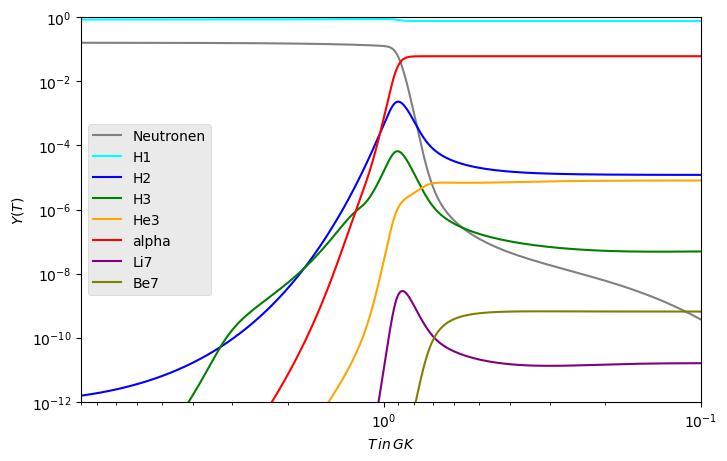

In [26]:
plt.close()
plt.figure(figsize = (8, 5))
plt.xlabel("$T\,in\,GK$")
plt.ylabel("$Y(T)$")
plt.style.use("ggplot")
plt.plot(sol_dT.t, sol_dT.y[0], label = "Neutronen", color="grey")
plt.plot(sol_dT.t, sol_dT.y[1], label = "H1", color="cyan")
plt.plot(sol_dT.t, sol_dT.y[2], label = "H2", color="blue")
plt.plot(sol_dT.t, sol_dT.y[3], label = "H3", color="green")
plt.plot(sol_dT.t, sol_dT.y[4], label = "He3", color="orange")
plt.plot(sol_dT.t, sol_dT.y[5], label = "alpha", color="red")
plt.plot(sol_dT.t, sol_dT.y[6], label = "Li7", color="purple")
plt.plot(sol_dT.t, sol_dT.y[7], label = "Be7", color="olive")

plt.xlim(9, 0.1)
plt.ylim(10**-12,1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()


In [28]:
Y_n=sol_dT.y[0]
Y_H1=sol_dT.y[1]
Y_H2=sol_dT.y[2]
Y_H3=sol_dT.y[3]
Y_He3=sol_dT.y[4]
Y_He4=sol_dT.y[5]
Y_Li7=sol_dT.y[6]
Y_Be7=sol_dT.y[7]

In [30]:
found=False
for i in range (0,len(sol_dT.t)):
    if found ==False:
        for j in range(7,8):
            if sol_dT.y[j][i]>10**(-12):
                print('All heavier particles exist at temperature T=',sol_dT.t[i],'GK','and lower temperatures.')
                found=True
    

All heavier particles exist at temperature T= 0.7923996734821953 GK and lower temperatures.


In [31]:
fig, ax = plt.subplots(figsize=(8,5))

particles=["$Y_{n}$", "$Y_{1H}$","$Y_{2H}$","$Y_{3H}$","$Y_{3He}$","$Y_{4He}$","$Y_{7Li}$","$Y_{7Be}$"]
palette = ["grey","cyan","blue","green","orange","red","purple","olive"]


total_frames=len(sol_dT.t)



def drawframe(i): #function to draw a single frame of the animation
    # i stands for the frame number
    
    
    
    ax.clear()
    ax.semilogy()
    plt.ylabel('Abundances $Y$')
    abundances=[Y_n[i], Y_H1[i], Y_H2[i], Y_H3[i], Y_He3[i], Y_He4[i], Y_Li7[i], Y_Be7[i]]
    ax.set_ylim(1*10**(-12),1)
    ax.text(6, 1*10**(-1), "T ="+str(np.round(sol_dT.t[i],3))+ " GK",fontsize=12)
    ax.text(6.5,1*10**(-3),"t ="+str(np.round(t_Value(sol_dT.t[i]),1))+ " s",fontsize=12)
    
    
    ax.bar(particles, abundances, color=palette)

    

anim = FuncAnimation(fig, drawframe,frames=total_frames, repeat=True,interval=100)
anim.save('nucleosynthesis2.gif',fps=25) # Save the animation as an gif
plt.close()

#Direct playing of the animations failed, but saving the animation locally and then calling the animation 
#in a markdown cell made the visualization posible

![Reactions](nucleosynthesis2.gif)

# Für dt jetzt

In [ ]:
def T_value(t):
    return 14.0/(t**(1/2))


def t_Value(T):
    return (T/14.0)**-2

t_min=t_Value(9)
t_max= t_Value(0.1)
t_span=[t_min,t_max]
t_span

#t_Value(9)

In [ ]:
def master_equation_for_dt(t, N_liste):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    Tdef=T_value(t)
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + dY_beta[0] 
            dY_liste[1] =dY_liste[1] + dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart(Tdef, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                
                dY_liste[num_a] =dY_liste[num_a] + dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                
                dY_four_particles=drv_fourthpart(Tdef, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] +  dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + dY_four_particles[3]

    return dY_liste



In [ ]:
r_tol = 1e-10
a_tol = 1e-10
sol2 = solve_ivp(master_equation_for_dt, t_span, Menge_liste, method="BDF",max_step=0.5, atol=a_tol,rtol=r_tol)

In [ ]:
plt.figure(figsize = (10, 5))
plt.xlabel("$t\,in\,s$")
plt.ylabel("$Y(T)$")
plt.plot(sol2.t, sol2.y[0], label = "Neutronen")
plt.plot(sol2.t, sol2.y[1], label = "H1")
plt.plot(sol2.t, sol2.y[2], label = "H2")
plt.plot(sol2.t, sol2.y[3], label = "H3")
plt.plot(sol2.t, sol2.y[4], label = "He3")
plt.plot(sol2.t, sol2.y[5], label = "alpha")
plt.plot(sol2.t, sol2.y[6], label = "Li7")
plt.plot(sol2.t, sol2.y[7], label = "Be7")

plt.xlim(t_min, t_max)
plt.ylim(10**-12,1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# Für eta

In [ ]:
def drv_gammapart_eta(T, eta_value,N_liste,part1,part2,part3,r_number): #Das ist für dydt     
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    dYa=-Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYb=-Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYc=Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)/(1+kron_delta(part1,part2))-lambda_gamma(T,part1,part2,part3,r_number)*Yc
    return np.array([dYa, dYb, dYc])

In [ ]:
def drv_fourthpart_eta(T, eta_value,N_liste,part1,part2,part3,part4,r_number): #Das ist für dydt
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    Yd = N_liste[part4.number]
    Term1 =-Ya * Yb * n_eta(T,eta_value) * ov_T(T,r_number)
    Term2 = (1 + kron_delta(part1, part2)) / (1 + kron_delta(part3, part4)) * n_eta(T,eta_value) * Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number)
    Term3 = (1 + kron_delta(part3, part4)) / (1 + kron_delta(part1, part2)) * Ya * Yb * n_eta(T,eta_value) * ov_T(T,r_number)
    Term4 =-Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number) *  n_eta(T,eta_value) 
    
    dYa=Term1+Term2
    dYb=Term1+Term2
    dYc=Term3+Term4
    dYd=Term3+Term4
    
    return np.array([dYa, dYb, dYc,dYd])

In [ ]:
def master_equation_for_eta(T, N_liste,eta_value):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + -392 / (T ** 3) * dY_beta[0] 
            dY_liste[1] =dY_liste[1] + -392 / (T ** 3) * dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart_eta(T, eta_value, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                dY_four_particles=drv_fourthpart_eta(T, eta_value, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

    return dY_liste


In [ ]:
eta_span=np.linspace(1*10**(-10),10*10**(-10), num=100, endpoint=True)


In [ ]:
sol_eta = [0 for x in range(100)]

In [ ]:

for i in range(0,100):
    
    sol_eta[i] = solve_ivp(master_equation_for_eta, T_span, Menge_liste,args=(eta_span[i],), method="BDF",max_step=0.01, atol=a_tol,rtol=r_tol)

In [ ]:
sol_eta

In [ ]:
y1 = 0.240
y2 = 0.258


y3 = 2.61 *10**(-5)
y4 = 3.03 *10**(-5)


y5 = 1.26 *10**(-10)
y6 = 2.14 *10**(-10)

x=eta_span
yHe4= [0 for x in range(100)]
YdYp=[0 for x in range(100)]
YLiYp=[0 for x in range(100)]

for i in range(0,100):
    yHe4[i]=4*sol_eta[i].y[5][-1]
for i in range(0,100):
    YdYp[i]=sol_eta[i].y[2][-1] / sol_eta[i].y[1][-1]
    
for i in range(0,100):
    YLiYp[i]=sol_eta[i].y[2][-1] / sol_eta[i].y[1][-1]
    



In [ ]:
plt.close()

plt.figure(figsize=(6,9))
plt.fill_between(x,y1, y2,color="orange")
plt.axhline(y=0.249, color='r', linestyle='-',linewidth=0.5)
plt.plot(x, yHe4, label = "4Y4He", color='tab:brown')
plt.title('4Y4He')
plt.xlabel("$eta\,in\,s$")
plt.ylabel("$Y(eta,0.1GK)$")


plt.yscale('log')
plt.xscale('log')


plt.legend()
plt.show()

In [ ]:
eta_for_Y4He4=[]
foundY4He4=False
for i in range (1,100):
    if foundY4He4 ==False:
        if yHe4[i]< y2:
            if yHe4[i]> y1:
                eta_for_Y4He4.append(x[i])
            else:
                foundY4He4=False
                
[eta_for_Y4He4[0],eta_for_Y4He4[-1]]

In [ ]:
plt.close()

plt.yscale('log')
plt.xscale('log')
plt.axhline(y=2.82*10**(-5), color='r', linestyle='-')
plt.plot(x, YdYp, label = "YdYp", color='tab:brown')
plt.fill_between(x,y3, y4,color="orange")
plt.title('YdYp')
plt.xlabel("$eta$")
plt.ylabel("$Y(eta,0.1GK)$")

plt.legend()
plt.show()

eta_span=np.linspace(1*10**(-10),10*10**(-10), num=100, endpoint=True)

In [ ]:
eta_for_YdYp=[]
foundYd=False
for i in range (1,90):
    if foundYd ==False:
        if YdYp[i]< y4:
            if YdYp[i]> y3:
                eta_for_YdYp.append(x[i])
            else:
                foundYd=False
                
print('Intervall, wo die Werte einstimmen:',[eta_for_YdYp[0],eta_for_YdYp[-1]])

In [ ]:
plt.close()

plt.yscale('log')
plt.xscale('log')

plt.plot(x, yHe4, label = "YLiYp", color='tab:brown')
plt.axhline(y= 1.7*10**(-10), color='r', linestyle='-',linewidth=0.5)
plt.fill_between(x,y5, y6, color='orange')
plt.title('YLiYp')
plt.xlabel("$eta\,in\,s$")
plt.ylabel("$Y(eta,0.1GK)$")

plt.legend()
plt.show()


Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 304, in process
    func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\matplotlib\animation.py", line 900, in _start
    self._init_draw()
  File "C:\Users\User\anaconda3\lib\site-packages\matplotlib\animation.py", line 1740, in _init_draw
    self._draw_frame(frame_data)
  File "C:\Users\User\anaconda3\lib\site-packages\matplotlib\animation.py", line 1759, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_1872\2856407517.py", line 27, in animate
    plt.bar(["$Y_{n}$", "$Y_{1H}$","$Y_{2H}$","$Y_{3H}$","$Y_{3He}$","$Y_{4He}$","$Y_{7Li}$","$Y_{7Be}$"], [Yn,YH1,YH2,YH3,YHe3,YHe4,YLi7,YBe7], color=palette)
NameError: name 'palette' is not defined
